In [ ]:
from numpy import arange
from dask.array.core import from_array
from pyshtools.expand import MakeGridDH


def foo(b, c):
    return from_array(
        [
            (
                [[0]]
                if b.shape[1] == 1
                else (
                    MakeGridDH(b[i_frequency].real, sampling=2, lmax=2)
                    + 1.0j * MakeGridDH(c[i_frequency].imag, sampling=2, lmax=2)
                )
            )
            for i_frequency in range(b.shape[0])
        ],
        chunks=(2, 6, 12),
    )


a = arange(576).reshape((32, 2, 3, 3))
b = from_array(a, chunks=(2, -1, -1, -1))
c = from_array(a, chunks=(2, -1, -1, -1))
b = b.map_blocks(foo, c)
e = b.compute()
# TODO :
"""
remove environment
create environment with gmt at the end of the command
install pygfo... requirements (python -m pip...)
install pygfo... (also)
modify snrei requirement file by removing dask ? include ditributed ? tried with both. Tried with dist. Tried with dask
install snrei requirements (also)

try with different G/FO solutions
"""

: 

In [5]:
e

array([[[[ 1.86125603e+01+0.j,  1.86125603e+01+0.j,
           1.86125603e+01+0.j, ...,  1.86125603e+01+0.j,
           1.86125603e+01+0.j,  1.86125603e+01+0.j],
         [ 3.19616968e+01+0.j,  5.41613675e+01+0.j,
           5.86658592e+01+0.j, ..., -2.90788744e+01+0.j,
          -2.15648743e+01+0.j,  1.81528820e+00+0.j],
         [ 3.02793321e+01+0.j,  6.66420419e+01+0.j,
           6.54890241e+01+0.j, ..., -5.70307405e+01+0.j,
          -5.75265668e+01+0.j, -2.24555739e+01+0.j],
         [ 1.57119327e+01+0.j,  4.68059597e+01+0.j,
           3.70197977e+01+0.j, ..., -4.47167978e+01+0.j,
          -5.89999357e+01+0.j, -3.27304342e+01+0.j],
         [ 1.60446596e+00+0.j,  1.42799111e+01+0.j,
           2.07771468e+00+0.j, ..., -8.56126150e+00+0.j,
          -2.79862760e+01+0.j, -2.11520732e+01+0.j],
         [-5.17017005e-01+0.j, -2.00461076e+00+0.j,
          -8.54929779e+00+0.j, ...,  1.55867571e+01+0.j,
           4.17156901e+00+0.j, -6.85058633e-01+0.j]],

        [[ 1.08038698e+02+

In [1]:
from snrei.utils.filtering.utils import map_from_collection_SH, collection_SH_from_map
from numpy import arange, array
from pyshtools.expand import MakeGridDH

a = arange(72).reshape((2, 3, 3, 4))
b = array(object=[MakeGridDH(a[:, :, :, i_frequency], sampling=2, lmax=2) for i_frequency in range(4)])

b - map_from_collection_SH(
    collection=collection_SH_from_map(frequencial_spatial_load_signal=b, n_max=2, n_frequencies_chunk=4),
    n_max=2,
    n_frequencies_chunk=4,
)

/home/mrousselet/anaconda3/envs/snrei_venv/lib/python3.12/site-packages/pymssa/mssa.py:10: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


array([[[ 1.42108547e-14,  1.42108547e-14,  1.42108547e-14,
          1.42108547e-14,  1.42108547e-14,  1.42108547e-14,
          1.42108547e-14,  1.42108547e-14,  1.42108547e-14,
          1.42108547e-14,  1.42108547e-14,  1.42108547e-14],
        [ 5.68434189e-14,  1.13686838e-13,  1.13686838e-13,
          5.68434189e-14,  1.42108547e-14, -2.84217094e-14,
         -1.42108547e-14, -5.68434189e-14, -5.68434189e-14,
         -5.68434189e-14, -7.10542736e-14, -7.10542736e-15],
        [ 5.68434189e-14,  1.13686838e-13,  2.27373675e-13,
          1.13686838e-13,  2.84217094e-14, -2.13162821e-14,
          0.00000000e+00,  0.00000000e+00, -5.68434189e-14,
         -1.13686838e-13, -1.98951966e-13, -9.94759830e-14],
        [ 5.68434189e-14,  1.13686838e-13,  1.13686838e-13,
         -1.42108547e-14, -1.27897692e-13, -9.94759830e-14,
          7.10542736e-15,  5.68434189e-14,  3.55271368e-14,
         -8.52651283e-14, -1.42108547e-13, -1.13686838e-13],
        [ 2.48689958e-14,  8.5265128

In [3]:
from pandas import read_csv
from pathlib import Path

df = read_csv(Path('.').joinpath("data/results/tables/harmonic_load_signal_trends.csv"))

/tmp/ipykernel_6165/3332041302.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["Love_numbers_ID"] == 0][df["erode_high_signal_zones"] == False][
/tmp/ipykernel_6165/3332041302.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["Love_numbers_ID"] == 0][df["erode_high_signal_zones"] == False][
/tmp/ipykernel_6165/3332041302.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["Love_numbers_ID"] == 0][df["erode_high_signal_zones"] == False][
/tmp/ipykernel_6165/3332041302.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["Love_numbers_ID"] == 0][df["erode_high_signal_zones"] == False][
/tmp/ipykernel_6165/3332041302.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df[df["Love_numbers_ID"] == 0][df["erode_high_signal_zones"] == False][
/tmp/ipykernel_6165/3332041302.py:5: UserWarning: Boolean Series 

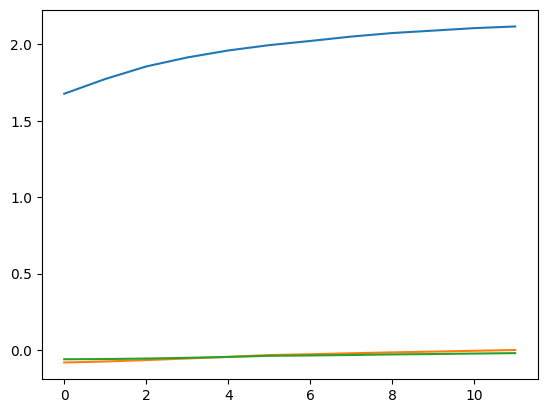

In [21]:
from matplotlib.pyplot import plot

for leakage_correction_iterations in range(3):
    plot(
        df[df["Love_numbers_ID"] == 0][df["erode_high_signal_zones"] == False][
            df["leakage_correction_iterations"] == leakage_correction_iterations
        ]
        .sort_values(by="pixels_to_coast")["ocean_mean_step_3"]
        .values
    )

In [6]:
from pathlib import Path

from pandas import DataFrame

from snrei import load_base_model, results_path

all_attributes = ["model", "run", "signal", "load", "case", "LIA", "continents"]


def process_files(
    path: Path = results_path,
):
    data = {}
    # Loops on files.
    for model_path in path.glob("*"):
        for run_path in model_path.joinpath("runs").glob("*"):
            for file_path in run_path.joinpath("load").glob("*/*/*/*/*/barystatic_rise_mean_trend.json"):
                barystatic_sea_level = load_base_model(path=file_path.parent, name=file_path.name)
                parents = str(file_path.parent).split("/")
                # Line.
                run_options = run_path.name.split("__")
                model_parts = model_path.name.split("_____")
                model = "_____".join(
                    model_parts
                    if not "" in run_options
                    else (model_parts[:2] if not "short_term_anelasticity" in run_options else (model_parts[0], model_parts[2]))
                )
                line = {
                    "model": model,
                    "run": run_path.name.split("bounded")[0],
                    "load function": (
                        parents[-5],
                        parents[-4],
                        parents[-3],
                        parents[-2],
                        parents[-1],
                    ),
                    "barystatic_difference_with_elastic": round(
                        number=barystatic_sea_level["anelastic"] - barystatic_sea_level["elastic"], ndigits=5
                    ),
                }
                for key, value in line.items():
                    if not key in data.keys():
                        data[key] = []
                    data[key] += [value]
    return DataFrame(data).drop_duplicates()


# Example usage:
df = process_files()
df.to_csv(results_path.joinpath("barystatic_sea_level_differences_with_elastic.csv"))

In [7]:
from pandas import read_csv

df = read_csv(results_path.joinpath("barystatic_sea_level_differences_with_elastic.csv"))
df

,Unnamed: 0,model,run,load function,barystatic_difference_with_elastic
0,0,PREM_____Benjamin_Q_QM1____asymptotic_mu_ratio...,__short_term_anelasticity__,"('ocean_load', 'Frederikse', 'upper', 'without...",0.18317
1,1,PREM_____Benjamin_Q_QM1____asymptotic_mu_ratio...,__short_term_anelasticity__,"('ocean_load', 'Frederikse', 'upper', 'without...",0.16587
2,2,PREM_____Benjamin_Q_QM1____asymptotic_mu_ratio...,__short_term_anelasticity__,"('ocean_load', 'Frederikse', 'upper', 'with_LI...",0.17914
3,3,PREM_____Benjamin_Q_QM1____asymptotic_mu_ratio...,__short_term_anelasticity__,"('ocean_load', 'Frederikse', 'upper', 'with_LI...",0.16297
4,4,PREM_____Benjamin_Q_QM1____asymptotic_mu_ratio...,__short_term_anelasticity__,"('ocean_load', 'Frederikse', 'mean', 'without_...",0.19581
...,...,...,...,...,...
2095,5395,PREM_____Lau_2016____eta_m__ASTHENOSPHERE__3e+...,long_term_anelasticity__short_term_anelasticity__,"('ocean_load', 'Frederikse', 'mean', 'with_LIA...",0.16495
2096,5396,PREM_____Lau_2016____eta_m__ASTHENOSPHERE__3e+...,long_term_anelasticity__short_term_anelasticity__,"('ocean_load', 'Frederikse', 'lower', 'without...",0.20999
2097,5397,PREM_____Lau_2016____eta_m__ASTHENOSPHERE__3e+...,long_term_anelasticity__short_term_anelasticity__,"('ocean_load', 'Frederikse', 'lower', 'without...",0.18542
2098,5398,PREM_____Lau_2016____eta_m__ASTHENOSPHERE__3e+...,long_term_anelasticity__short_term_anelasticity__,"('ocean_load', 'Frederikse', 'lower', 'with_LI...",0.19882


In [8]:
# General variability: statistics computed using all models and all load functions.
# TODO: mean -> reference model.
df.groupby(["run"]).agg({"barystatic_difference_with_elastic": ["min", "mean", "max", "std"]})

barystatic_difference_with_elastic  \
                                                                                 min   
run                                                                                    
__short_term_anelasticity__                                                  0.13717   
long_term_anelasticity____                                                   0.00657   
long_term_anelasticity__short_term_anelasticity__                            0.14320   

                                                                                
                                                       mean      max       std  
run                                                                             
__short_term_anelasticity__                        0.182056  0.24571  0.022760  
long_term_anelasticity____                         0.031217  0.06343  0.015684  
long_term_anelasticity__short_term_anelasticity__  0.211891  0.30047  0.028046

In [11]:
# Load function mean variability: mean (per model) of standard deviation (per load function).
df.groupby(["model", "run"]).agg(
    {"barystatic_difference_with_elastic": ["std"]}
).groupby(["run"]).agg({("barystatic_difference_with_elastic", "std"): ["mean", "max"]})

barystatic_difference_with_elastic  \
                                                                                 std   
                                                                                mean   
run                                                                                    
__short_term_anelasticity__                                                 0.013257   
long_term_anelasticity____                                                  0.005021   
long_term_anelasticity__short_term_anelasticity__                           0.016315   

                                                             
                                                             
                                                        max  
run                                                          
__short_term_anelasticity__                        0.015955  
long_term_anelasticity____                         0.007185  
long_term_anelasticity__short_term_anelasticity__  0.020525

In [12]:
# Model mean variability: mean (per load function) of standard deviation (per model).
df.groupby(["run",  "load function"]).agg(
    {"barystatic_difference_with_elastic": ["std"]}
).groupby(["run"]).agg({("barystatic_difference_with_elastic", "std"): ["mean", "max"]})

barystatic_difference_with_elastic  \
                                                                                 std   
                                                                                mean   
run                                                                                    
__short_term_anelasticity__                                                 0.019502   
long_term_anelasticity____                                                  0.015646   
long_term_anelasticity__short_term_anelasticity__                           0.023436   

                                                             
                                                             
                                                        max  
run                                                          
__short_term_anelasticity__                        0.022742  
long_term_anelasticity____                         0.020112  
long_term_anelasticity__short_term_anelasticity__  0.028742